#### 퍼널 분석

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

#주피터 노트북 너비 설정
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 70% !important; }</style>"))

In [2]:
df = pd.read_csv('events.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     885129 non-null  object 
 1   event_type     885129 non-null  object 
 2   product_id     885129 non-null  int64  
 3   category_id    885129 non-null  int64  
 4   category_code  648910 non-null  object 
 5   brand          672765 non-null  object 
 6   price          885129 non-null  float64
 7   user_id        885129 non-null  int64  
 8   user_session   884964 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 60.8+ MB


In [5]:
df.describe()

,product_id,category_id,price,user_id
count,8.851290e+05,8.851290e+05,885129.000000,8.851290e+05
mean,1.906621e+06,2.144423e+18,146.328713,1.515916e+18
std,1.458708e+06,6.165105e+14,296.807683,3.747287e+07
min,1.020000e+02,2.144416e+18,0.220000,1.515916e+18
25%,6.988030e+05,2.144416e+18,26.460000,1.515916e+18
50%,1.452883e+06,2.144416e+18,65.710000,1.515916e+18
75%,3.721194e+06,2.144416e+18,190.490000,1.515916e+18
max,4.183880e+06,2.227847e+18,64771.060000,1.515916e+18


In [3]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ


In [4]:
df_events = df[['user_session', 'event_type']].drop_duplicates()

In [5]:
#퍼널 전환율 계산
funnel = pd.DataFrame(df_events.groupby('event_type')['user_session'].count()).reset_index()

* 이벤트 타입은 'view', 'cart', 'purchase' 3단계로 나뉘어져 있음.
    - view: 페이지 조회
    - cart: 장바구니
    - purchase: 구매
* view -> cart -> purchase 순서로 퍼널 단계를 설정하고 단계별 전환율을 계산함.

In [6]:
stage = {
    'view': 0,
    'cart': 1,
    'purchase': 2
}

funnel['stage'] = funnel['event_type'].map(stage)

In [7]:
funnel = funnel.sort_values(by='stage').reset_index()

In [8]:
del funnel['index']

In [9]:
for i in range(len(funnel)):
    if i==0:
        funnel.loc[i, 'conversion_rate'] = None
    else:
        funnel.loc[i, 'conversion_rate'] = round(funnel.loc[i, 'user_session'] / funnel.loc[i-1, 'user_session'] *100, 2)

In [10]:
funnel

,event_type,user_session,stage,conversion_rate
0,view,488360,0,NaN
1,cart,41270,1,8.45
2,purchase,24344,2,58.99


In [57]:
#시각화
fig = go.Figure(go.Funnel(name='Funnel Conversion',
                x=funnel['user_session'],
                y=funnel['event_type'],
                textinfo = "value+percent previous"
                    )
               )
fig.update_layout(height=400, width=500, title_text="Funnel Conversion")
fig.show()

* view -> cart 전환율은 8.45%
* cart -> purshase 전환율은 58.99%
* 장바구니에 상품을 담은 경우 구매로 이어지는 경우가 절반 이상.
* 반면 페이지 조회 후 장바구니 이용으로 이어질 확률이 낮아 고객들이 원하는 상품이 없는 것은 아닌지 의심됨.

###### 고객 segmentation
* 고객군별로 전환율의 양상이 다르게 나타나는지 확인하기 위해 먼저 고객 segmentation을 진행함.
* 기본적을 RFM 프레임워크를 사용했으며, 여기에 브랜드 제품 구매 비율 변수를 추가함.

In [12]:
df['datetime'] = pd.to_datetime(df['event_time'])

In [16]:
df_purchase = df[df['event_type']=='purchase'] #제품을 구매한 고객 데이터만 대상으로 함.
recent_date = pd.DataFrame(df_purchase.groupby(['user_id'])['datetime'].max().reset_index())

recent_date['recency'] = recent_date.datetime > '2020-12-01'

In [17]:
# Frequency: 고객별 주문건수 확인
# 주문 건별 아이디가 없어 같은 세션에서 구매했으면 같은 주문일 것으로 가정하고 세션을 카운트함.
freq = pd.DataFrame(df_purchase.groupby(['user_id'])['user_session'].count()).reset_index()
freq = freq.rename(columns={'user_session':'orders'})

In [18]:
# Monetary: 고객별 주문금액 집계
monetary = pd.DataFrame(df_purchase.groupby(['user_id'])['price'].sum()).reset_index()

In [19]:
# 브랜드 상품 구매 비율 계산
brand_purchase = pd.DataFrame(df_purchase.groupby(['user_id']).count()[['product_id', 'brand']]).reset_index()
brand_purchase['brand_pref'] = brand_purchase['brand'] / brand_purchase['product_id']

In [20]:
rf = pd.merge(recent_date, freq, how='right', on='user_id')
rfm = pd.merge(rf, monetary, how='right', on='user_id')
brand_purchase = brand_purchase[['user_id', 'brand_pref']]
rfmb = pd.merge(rfm, brand_purchase, how='right', on='user_id')
del rfmb['datetime']

<AxesSubplot:>

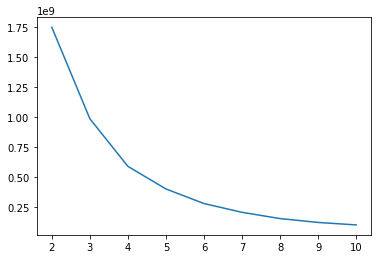

In [21]:
from sklearn.cluster import KMeans
rfmb = pd.get_dummies(rfmb, columns=['recency'], drop_first = True)
rfmb.set_index('user_id', inplace=True)


#적정그룹수 정하기
inertia = []

for i in range(2, 11):
    model = KMeans(n_clusters=i)
    model.fit(rfmb)
    inertia.append(model.inertia_)
    
sns.lineplot(x=list(range(2,11)), y=inertia)

In [22]:
# 4개를 클러스터 개수로 정하고 클러스터링 진행

model = KMeans(n_clusters=4)
model.fit(rfmb)
rfmb['cluster'] = model.labels_

In [23]:
pd.DataFrame(rfmb.groupby(by='cluster')['orders'].count()).rename(columns={'orders':'users'})

,users
cluster,
0,16574
1,812
2,85
3,3833


In [24]:
summary = rfmb.groupby('cluster').mean().reset_index()

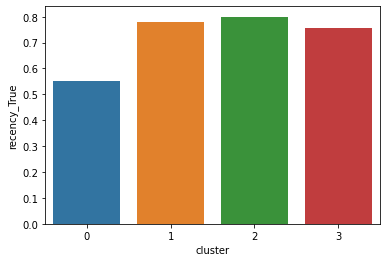

In [62]:
sns.barplot(x='cluster', y='recency_True', data=summary)
plt.savefig('plots/cluster_recency.png')

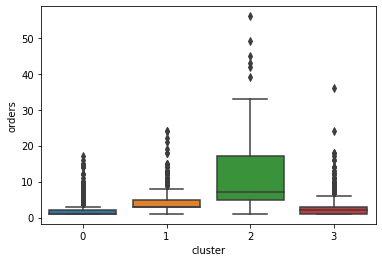

In [63]:
sns.boxplot(x='cluster', y='orders', data=rfmb)
plt.savefig('plots/cluster_orders.png')

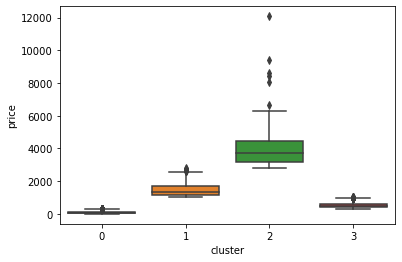

In [64]:
sns.boxplot(x='cluster', y='price', data=rfmb)
plt.savefig('plots/cluster_price.png')

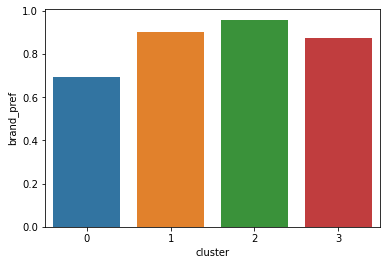

In [65]:
sns.barplot(x='cluster', y='brand_pref', data=summary)
plt.savefig('plots/cluster_brand_pref.png')

In [29]:
rfmb_re = rfmb[['cluster']].reset_index()

* 다시 퍼널분석을 진행하기 위해 raw 데이터에 cluster 결과를 merge한다.

In [30]:
df = pd.merge(df, rfmb_re, on='user_id', how='left')

* 구매행위를 전혀하지 않은 고객군을 '4'번 그룹으로 설정함.

In [31]:
df['cluster'] = df['cluster'].fillna(4)

In [67]:
df.to_csv('events_w_cluster.csv')  #추후 추가 분석을 위해 저장

In [50]:
#그룹별 고객 수 계산
group_users_cnt = pd.DataFrame(df.groupby(by='cluster')['user_id'].count())
group_users_cnt['percentage'] = group_users_cnt.div(group_users_cnt.sum(axis=0)) * 100
group_users_cnt

,user_id,percentage
cluster,,
0.0,116776,13.193105
1.0,18810,2.125114
2.0,4251,0.480269
3.0,47164,5.328489
4.0,698128,78.873023


###### 고객 분류 결과 정리
* 0번 그룹
    - 최근 구매한 비율이 낮으며 평균 구매 건수가 1.5회 정도로 낮음. 
    - 구매액도 적은 편으로 저렴한 제품을 1~2회 구매했고 구매 빈도가 낮은 그룹.
    - 브랜드 제품을 구매한 비율도 낮음.
    - 전반적으로 충성도가 낮은 그룹. 전체 회원의 약 13%
* 1번 그룹
    - 구매 빈도가 4.3회로 비교적 높고 구매 건단가도 335불 정도로 높은 편임.
    - 브랜드를 구매한 비율이 90% 이상이며 최근 구매한 비율 역시 77.9%에 달함.
    - 비교적 꾸준히 제품을 구매할 의사가 있는 그룹으로 보임. 전체 회원의 2%
* 2번 그룹
    - 구매 빈도와 구매액이 모두 높고, 브랜드 제품 구매 비율이 95%에 달함.
    - 최근 구매한 비율도 80%인 VIP 그룹으로 충성도가 매우 높음.
    - 전체 회원의 0.48%에 그침.
* 3번 그룹
    - 구매 빈도와 구매액 모두 비교적 낮은 편이나 0번 그룹보다는 양호함.
    - 최근 구매 비율과 브랜드 제품 구매 비율은 양호한 편임.
    - 전체 회원의 5.3%를 차지함.
* 4번 그룹
    - 구매 경험이 전혀 없는 그룹.
    - 전체 회원의 78%에 달해 이들의 구매를 유도하는 것이 시급해 보임.

In [39]:
summary

,cluster,orders,price,brand_pref,recency_True
0,0,1.476530,89.896318,0.693196,0.552613
1,1,4.392857,1474.945591,0.902778,0.779557
2,2,11.976471,4164.590353,0.959274,0.800000
3,3,2.162536,543.649374,0.872340,0.757370


In [32]:
df_events = df[['user_session', 'cluster', 'event_type']].drop_duplicates()

In [33]:
#퍼널 전환율 계산
funnel_cluster = pd.DataFrame(df_events.groupby(['cluster', 'event_type'])['user_session'].count())

In [34]:
funnel_cluster_re = funnel_cluster.reset_index()

In [35]:
stage = {
    'view': 0,
    'cart': 1,
    'purchase': 2
}

funnel_cluster_re['stage'] = funnel_cluster_re['event_type'].map(stage)

In [36]:
funnel_cluster_re = funnel_cluster_re.sort_values(by=['cluster', 'stage'], ascending=True)

In [37]:
fun_cls_0 = funnel_cluster_re[funnel_cluster_re['cluster']==0]
fun_cls_1 = funnel_cluster_re[funnel_cluster_re['cluster']==1]
fun_cls_2 = funnel_cluster_re[funnel_cluster_re['cluster']==2]
fun_cls_3 = funnel_cluster_re[funnel_cluster_re['cluster']==3]
fun_cls_4 = funnel_cluster_re[funnel_cluster_re['cluster']==4]

In [54]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=2)

fig.add_trace(go.Funnel(
                        name='cluster 0',
                        x=fun_cls_0['user_session'],
                        y=fun_cls_0['event_type'],
                        textinfo = "value+percent previous"
                        ),
            row=1, col=1)

fig.add_trace(go.Funnel(
                        name='cluster 1',
                        x=fun_cls_1['user_session'],
                        y=fun_cls_1['event_type'],
                        textinfo = "value+percent previous"
                        ),
              row=1, col=2)


fig.add_trace(go.Funnel(
                        name='cluster 2',
                        x=fun_cls_2['user_session'],
                        y=fun_cls_2['event_type'],
                        textinfo = "value+percent previous"
                        ),
              row=2, col=1)

fig.add_trace(go.Funnel(
                        name='cluster 3',
                        x=fun_cls_3['user_session'],
                        y=fun_cls_3['event_type'],
                        textinfo = "value+percent previous"
                        ),
              row=2, col=2)

fig.add_trace(go.Funnel(
                        name='cluster 4',
                        x=fun_cls_4['user_session'],
                        y=fun_cls_4['event_type'],
                        textinfo = "value+percent previous"
                        ),
              row=3, col=1)

fig.update_layout(height=800, width=800, title_text="Funnel Conversion by Customer Cluster")

fig.show()

##### 분석 결과
* 구매를 전혀 하지 않은 4번 그룹을 제외하면 view -> cart 단계의 전환율이 양호함. 모두 50% 이상의 전환율을 보여주고 있음.
* 즉 view -> cart 단계 전환율을 제고하기 위해서는 4번 그룹의 활동을 활성화할 필요가 있음.
* 이들이 원하는 제품이 없어서 구매를 하지 않는 것인지, 아니면 그저 제품 정보를 찾기 위해 접속하는 것인지 확인해야 할 것으로 보임.
* 또한 4번 그룹은 cart -> purchase 단계의 전환율이 0임. 이들이 결제 과정을 진행하는 도중에 이탈하는 것인지, 아니면 결제 단계를 아예 진행하지 않은 것인지, 원인은 무엇인지 등을 확인할 필요가 있음. 
* 4번 그룹을 제외한 모든 그룹에서 cart -> purchase 단계의 전환율은 100%임. 즉, 장바구니에 담은 이후에는 대부분 결제로 연결됨. 따라서 결제 과정에서 특별한 불편함은 없는 것으로 예상됨.
* 0번 그룹의 경우 view -> cart 비율보다 view -> purchase 단계의 비율이 더 높음. 장바구니에 담지 않고 바로 구매를 하는 고객들이 존재한다는 의미임. 0번 그룹은 구매액이 작아 비교적 손쉽게 구매를 진행하는 것으로 해석됨.
* 충성도가 낮은 것으로 분석된 0번 그룹의 전환율이 1,2,3번 그룹보다 높음. 0번 그룹은 구매 빈도 대비 구매 의사는 비교적 확실해 보이므로 업셀링이나 크로스셀링을 유도하면 좋을 것으로 예상됨.